# ArbitraryDiscretiser + MeanEncoder

This is very useful for linear models, because by using discretisation + a monotonic encoding, we create monotonic variables with the target, from those that before were not originally. And this tends to help improve the performance of the linear model. 

## ArbitraryDiscretiser

The ArbitraryDiscretiser() divides continuous numerical variables into contiguous intervals arbitrarily defined by the user.

The user needs to enter a dictionary with variable names as keys, and a list of the limits of the intervals as values. For example {'var1': [0, 10, 100, 1000],'var2': [5, 10, 15, 20]}.

<b>Note:</b> Check out the ArbitraryDiscretiser notebook to learn more about this transformer.

## MeanEncoder

The MeanEncoder() replaces the labels of the variables by the mean value of the target for that label. <br>For example, in the variable colour, if the mean value of the binary target is 0.5 for the label blue, then blue is replaced by 0.5

<b>Note:</b> Read MeanEncoder notebook to know more about this transformer

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.encoding import MeanEncoder

plt.rcParams["figure.figsize"] = [15,5]

In [15]:
# Load titanic dataset from file

def load_titanic(filepath='titanic.csv'):
    # data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')
    data = pd.read_csv(filepath)
    data = data.replace('?', np.nan)
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['age'] = data['age'].astype('float').fillna(data.age.median())
    data['fare'] = data['fare'].astype('float').fillna(data.fare.median())
    data['embarked'].fillna('C', inplace=True)
    # data.drop(labels=['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1, inplace=True)
    return data

In [16]:
# data = load_titanic("../data/titanic.csv")
data = load_titanic("../data/titanic-2/Titanic-Dataset.csv")
data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,n,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,n,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,n,S


In [17]:
# let's separate into training and testing set
X = data.drop(['survived'], axis=1)
y = data.survived

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (623, 11)
X_test : (268, 11)


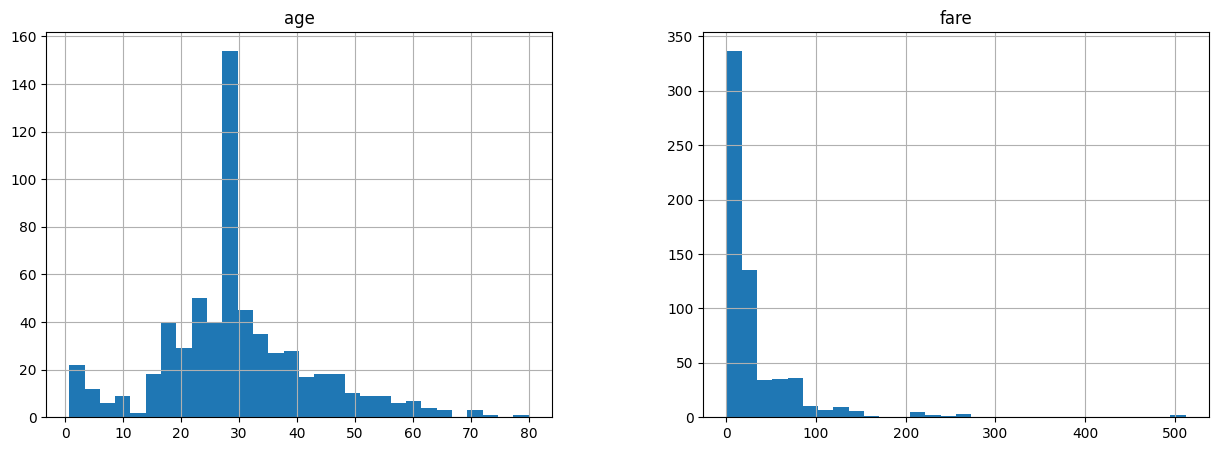

In [18]:
# we will transform two continuous variables
X_train[["age", 'fare']].hist(bins=30)
plt.show()

In [19]:
# set up the discretiser
arb_disc = ArbitraryDiscretiser(
    binning_dict={'age': [0, 18, 30, 50, 100],
                  'fare': [-1, 20, 40, 60, 80, 600]},
    # returns values as categorical
    return_object=True)

# set up the mean encoder
mean_enc = MeanEncoder(variables=['age', 'fare'])

# set up the pipeline
transformer = Pipeline(steps=[('ArbitraryDiscretiser', arb_disc),
                              ('MeanEncoder', mean_enc),
                              ])
# train the pipeline
transformer.fit(X_train, y_train)

Pipeline(steps=[('ArbitraryDiscretiser',
                 ArbitraryDiscretiser(binning_dict={'age': [0, 18, 30, 50, 100],
                                                    'fare': [-1, 20, 40, 60, 80,
                                                             600]},
                                      return_object=True)),
                ('MeanEncoder', MeanEncoder(variables=['age', 'fare']))])

In [20]:
transformer.named_steps['ArbitraryDiscretiser'].binner_dict_

{'age': [0, 18, 30, 50, 100], 'fare': [-1, 20, 40, 60, 80, 600]}

In [21]:
transformer.named_steps['MeanEncoder'].encoder_dict_

{'age': {0: 0.5,
  1: 0.3409090909090909,
  2: 0.42134831460674155,
  3: 0.3488372093023256},
 'fare': {0: 0.28774928774928776,
  1: 0.4357142857142857,
  2: 0.5555555555555556,
  3: 0.4594594594594595,
  4: 0.76}}

In [22]:
train_t = transformer.transform(X_train)
test_t = transformer.transform(X_test)

test_t.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
495,496,3,"Yousseff, Mr. Gerious",male,0.340909,0,0,2627,0.287749,n,C
648,649,3,"Willey, Mr. Edward",male,0.340909,0,0,S.O./P.P. 751,0.287749,n,S
278,279,3,"Rice, Master. Eric",male,0.500000,4,1,382652,0.435714,n,Q
31,32,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,0.340909,1,0,PC 17569,0.760000,B,C
255,256,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,0.340909,0,2,2650,0.287749,n,C


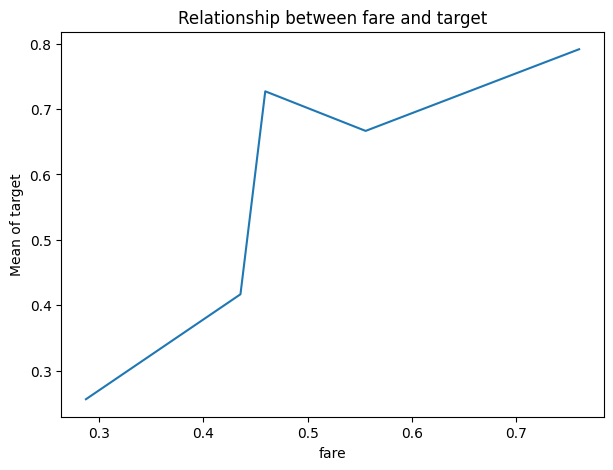

In [23]:
# let's explore the monotonic relationship
plt.figure(figsize=(7, 5))
pd.concat([test_t, y_test], axis=1).groupby("fare")["survived"].mean().plot()
plt.title("Relationship between fare and target")
plt.xlabel("fare")
plt.ylabel("Mean of target")
plt.show()

We can observe an almost linear relationship between the variable "fare" after the transformation and the target.